In [2]:
#Pipeline imports
%matplotlib inline
%load_ext autoreload
%autoreload 2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import wirc_drp.wirc_object as wo
import wirc_drp.constants as constants
from wirc_drp.utils import calibration, spec_utils as su, image_utils as iu
from wirc_drp.masks import *

First we'll set up all the directories. For this tutorial, we are using sample images already present in the 
WIRC+Pol DRP but these images are not part of a matching set of science and sky background frames. Thus, **DISCLAIMER**, the PCA background subtraction here is of poor quality and is simply meant to demonstrate how the technique works in the pipeline

In [5]:
wircpol_dir = os.environ['WIRC_DRP'] # Your WIRCPOL_DRP directory (with a "/" at the end!)
tutorial_dir = wircpol_dir + "Tutorial/sample_data/"

Here we create lists of filepaths to the .fits files used for background sky frames and science frames respectively. If you would like to actually test out the full capability of the PCA subtraction functionality, you'll need to manually set the filepaths to the appropriate directories of science and sky frames yourself. PCA works best when you have a large reference library of sky frames (the five frames in the "library" here are not sufficient in a normal everyday use context but are merely meant for demonstration purposes).

In [7]:
#background sky frames
sky_frames = [tutorial_dir+'wirc0141.fits',
                tutorial_dir+'wirc0142.fits',
                tutorial_dir+'wirc0158.fits',
                tutorial_dir+'wirc0159.fits',
                tutorial_dir+'wirc0160.fits']

sci_frame = tutorial_dir+'wirc0140.fits'

Let's read in the first science frame. 

In [8]:
image = wo.wirc_data(tutorial_dir+'wirc0140.fits')

Creating a new wirc_data object from file /home/meiji274/wirc_drp/Tutorial/sample_data/wirc0140.fits
Found a J-band filter in the header of file /home/meiji274/wirc_drp/Tutorial/sample_data/wirc0140.fits


Source Finding: 
--------------

First, let's find the sources in the image and see what the corresponding spectra look like.
To find sources in the image, we use the find_sources_v2 method.
There was already a find_sources() method in the pipeline, so I created a second one and labeled it _v2 to avoid
deleting the previous version.

KWARGS:

cross_correlation_template: 2-D np.array

    By default, uses the cross correlation template in masks subdirectory of wirc_drp, 
    but if you provide a template, it will use that instead. (default = None)

sigma_threshold: fl

    only keeps sources that have a flux above specified sigma threshold. (default = 0)

show_plots: bool

    if True, shows plots. (default = True)

Finding sources


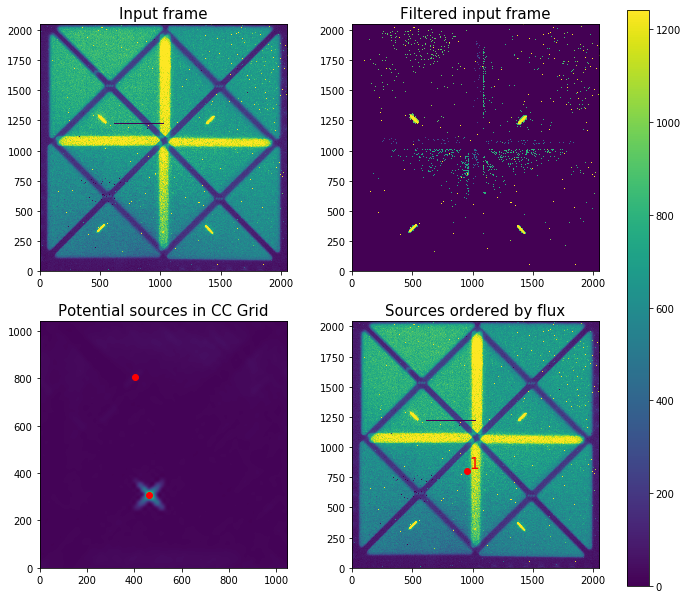

Source positions ordered by flux: [(956, 805)]
Trace fluxes: [10528]


In [4]:
image.find_sources_v2(sigma_threshold=0, show_plots=True)

Background Subtraction:
-------------------

In the next cell are examples of the five currently supported background subtraction methods

(1) 'shift_and_subtract': shifts the image by a specified amount and direction and then subtracts. *Default method*

(2) 'PCA' (Principal component analysis): See Soummer et al. (2012) for a description of the algorithm 

(3) 'median_ref': Median combines the reference library frames 

(4) 'scaled_bkg': Takes and scales a manually inputted background frame

(5) 'simple_median': Calculates the median pixel value of the image and subtracts that off the entire image 

I've called the generate_and_subtract_bkg function five times with different methods and the associated
kwargs to show the possible options.

In [ ]:
#don't actually run this cell
image.generate_bkg(method='shift_and_subtract', shift_dir='diagonal', bkg_sub_shift_size=31,
                                 filter_bkg_size=None)
image.generate_bkg(method='PCA', num_PCA_modes=10, ref_lib=sky_frames)
image.generate_bkg(method='median_ref', ref_lib=sky_frames)
image.generate_bkg(method='scaled_bkg', bkg_fn=sky_frames[0], bkg_by_quadrants=False)
image.generate_bkg(method='simple_median')

The function defaults to shift and subtract if you supply it with no arguments.

In [ ]:
image.generate_bkg()

PCA:
---

Let's try a few sample background subtractions. First, let's do PCA subtraction, you need to make sure a reference library has been read in. Just for convenience, it is possible to call the function with a ref_lib kwarg at the generate background step if you didn't earlier when instantiating the object using wo.wirc_data(ref_lib=ref_lib).
You also need to specify the kwarg "num_PCA_modes". 
This kwarg accepts integers in range: 0 < num_PCA_modes =< number of images in reference library

Creating a new wirc_data object from file /home/mmnguyen/Research/WIRC+POL/Data/20180421/Science/image0148.fits
Found a J-band filter in the header of file /home/mmnguyen/Research/WIRC+POL/Data/20180421/Science/image0148.fits
Finding sources


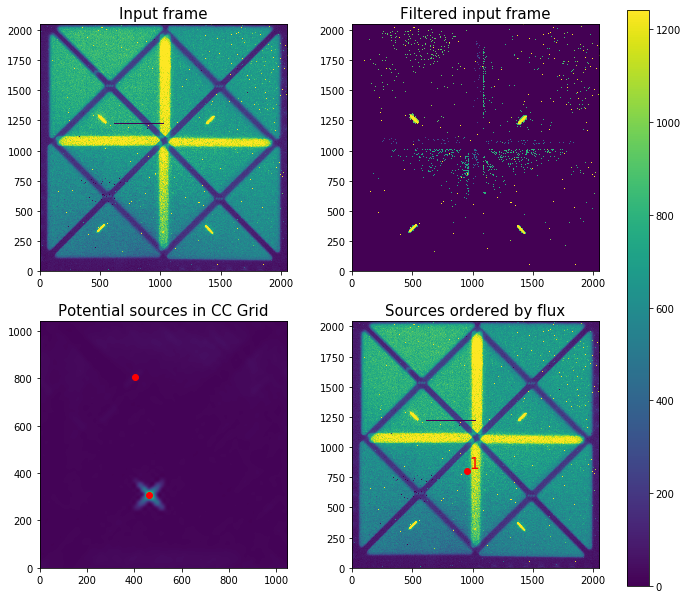

Source positions ordered by flux: [(956, 805)]
Trace fluxes: [10528]


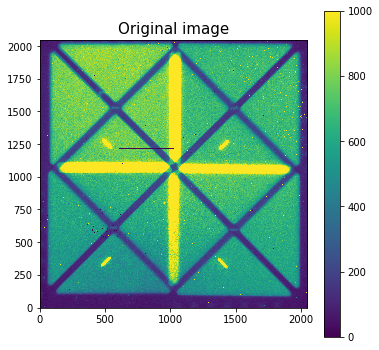

Subtracting background using PCA.
Performing PCA background subtraction using 10 modes


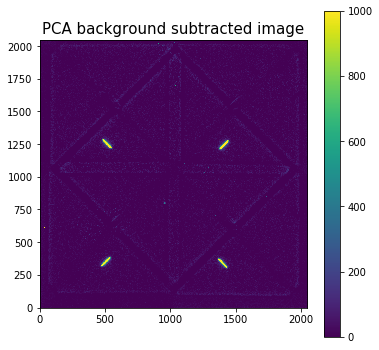

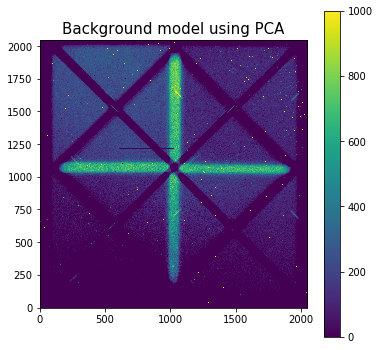

In [5]:
image = wo.wirc_data(sci_frames[5])

#find sources
image.find_sources_v2(sigma_threshold=0)

#let's see what the original image looks like
plt.figure(figsize=(6,6))
plt.title('Original image', fontsize=15)
plt.imshow(image.full_image, origin='lower', vmin=0, vmax=1000)
plt.colorbar()
plt.show()
plt.close()

#then we do PCA background subtraction
image.generate_and_subtract_bkg('PCA', num_PCA_modes=10, ref_lib=sky_frames)

#now let's see what the subtracted image looks like
plt.figure(figsize=(6,6))
plt.title('PCA background subtracted image', fontsize=15)
plt.imshow(image.full_image, origin='lower', vmin=0, vmax=1000)
plt.colorbar()
plt.show()
plt.close()

#we can also see what the model background image looks like as well
plt.figure(figsize=(6,6))
plt.title('Background model using PCA', fontsize=15)
plt.imshow(image.bkg_image, origin='lower', vmin=0, vmax=1000)
plt.colorbar()
plt.show()
plt.close()

Let's see how the corresponding spectra turned out

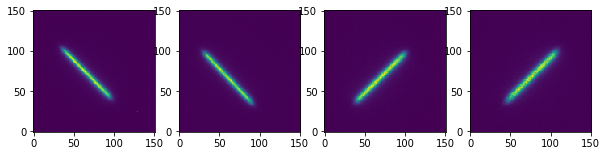

In [11]:
image.source_list[0].get_cutouts(image.full_image, image.DQ_image, image.filter_name,
                                 replace_bad_pixels = True, sub_bar = False, cutout_size = 75)

#plot the traces
fig, ax = plt.subplots(1,4,figsize = (10,4))
for i in range(4):
    ax[i].imshow(image.source_list[0].trace_images[i], origin = 'lower')

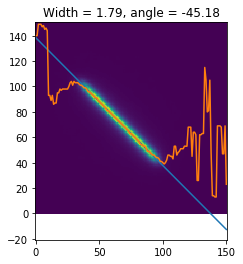

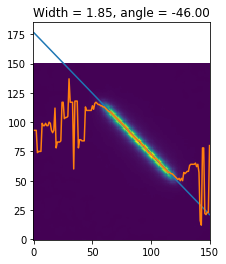

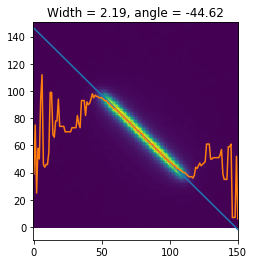

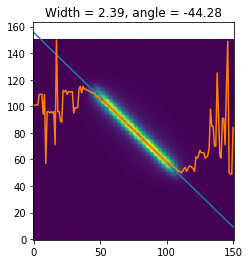

In [12]:
image.source_list[0].extract_spectra(plot=False, 
                                   method="optimal_extraction", 
                                   spatial_sigma=10,
                                   bad_pix_masking = 1,
                                   plot_optimal_extraction = False,
                                   plot_findTrace = True,
                                   verbose=False)

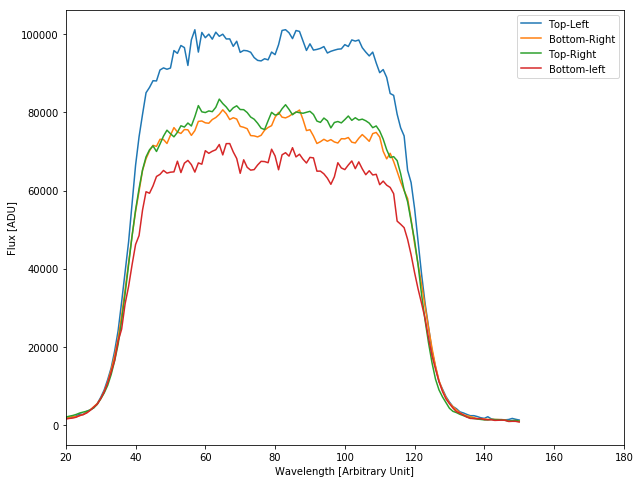

In [13]:
image.source_list[0].plot_trace_spectra(figsize=(10,8), xlow = 20, xhigh = 180)

Shift and Subtract:
    ---

Next let's try shift_and_subtract

Creating a new wirc_data object from file /home/mmnguyen/Research/WIRC+POL/Data/20180421/Science/image0148.fits
Found a J-band filter in the header of file /home/mmnguyen/Research/WIRC+POL/Data/20180421/Science/image0148.fits
Finding sources


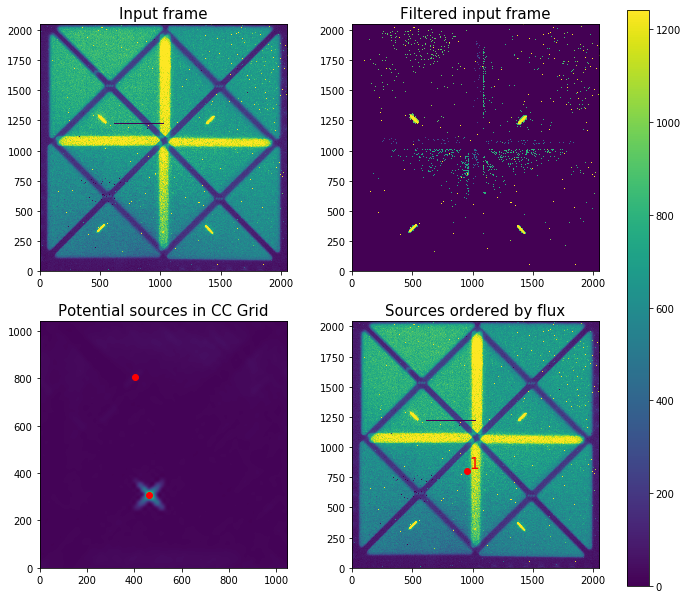

Source positions ordered by flux: [(956, 805)]
Trace fluxes: [10528]


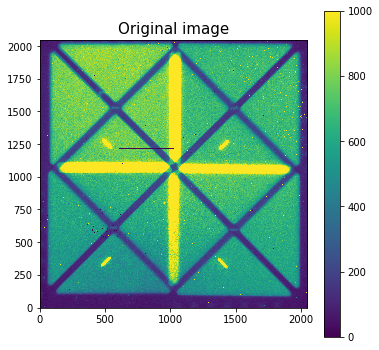

Subtracting background using shift and subtract method.


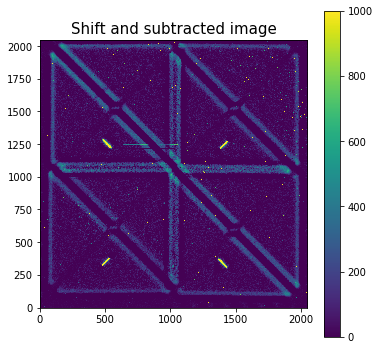

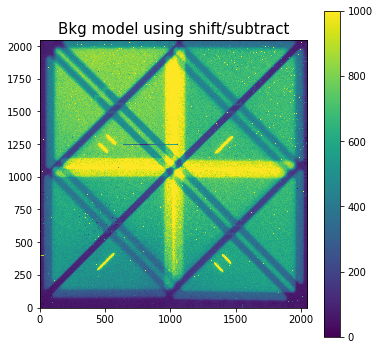

In [19]:
image = wo.wirc_data(sci_frames[5])

#find sources
image.find_sources_v2(sigma_threshold=0)

#let's see what the original image looks like
plt.figure(figsize=(6,6))
plt.title('Original image', fontsize=15)
plt.imshow(image.full_image, origin='lower', vmin=0, vmax=1000)
plt.colorbar()
plt.show()
plt.close()

#then we do shift_and_subtract background subtraction
image.generate_and_subtract_bkg()

#now let's see what the subtracted image looks like
plt.figure(figsize=(6,6))
plt.title('Shift and subtracted image', fontsize=15)
plt.imshow(image.full_image, origin='lower', vmin=0, vmax=1000)
plt.colorbar()
plt.show()
plt.close()

#we can also see what the model background image looks like as well
plt.figure(figsize=(6,6))
plt.title('Bkg model using shift/subtract', fontsize=15)
plt.imshow(image.bkg_image, origin='lower', vmin=0, vmax=1000)
plt.colorbar()
plt.show()
plt.close()

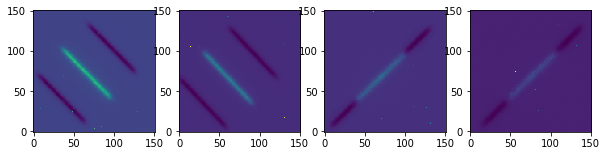

In [20]:
image.source_list[0].get_cutouts(image.full_image, image.DQ_image, image.filter_name,
                                 replace_bad_pixels = True, sub_bar = False, cutout_size = 75)

#plot the traces
fig, ax = plt.subplots(1,4,figsize = (10,4))
for i in range(4):
    ax[i].imshow(image.source_list[0].trace_images[i], origin = 'lower')

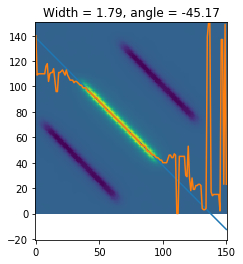

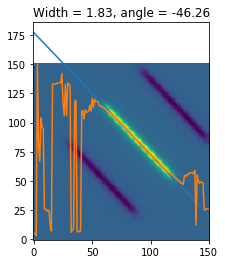

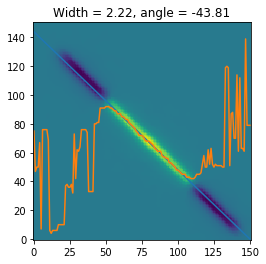

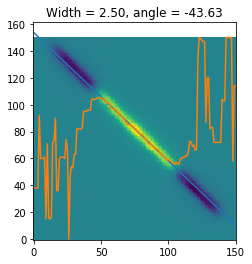

In [21]:
image.source_list[0].extract_spectra(plot=False, 
                                   method="optimal_extraction", 
                                   spatial_sigma=10,
                                   bad_pix_masking = 1,
                                   plot_optimal_extraction = False,
                                   plot_findTrace = True,
                                   verbose=False)

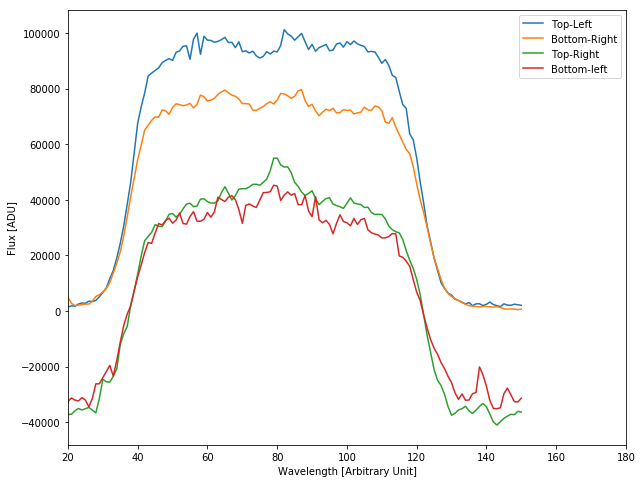

In [22]:
image.source_list[0].plot_trace_spectra(figsize=(10,8), xlow = 20, xhigh = 180)

Scaled Background:
    ---

Let's do one more using a scaled background that we manually input 

Creating a new wirc_data object from file /home/mmnguyen/Research/WIRC+POL/Data/20180421/Science/image0148.fits
Found a J-band filter in the header of file /home/mmnguyen/Research/WIRC+POL/Data/20180421/Science/image0148.fits
Finding sources


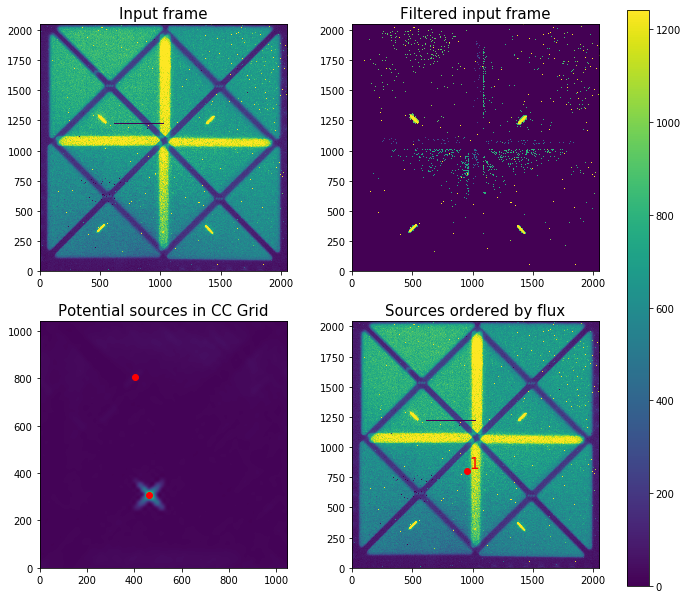

Source positions ordered by flux: [(956, 805)]
Trace fluxes: [10528]


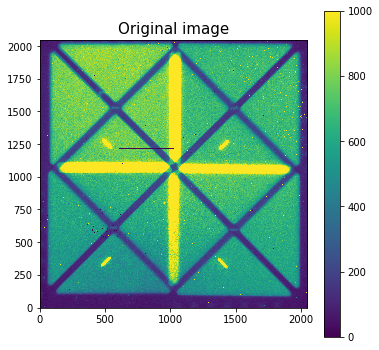

Subtracting background using scaled background frame.


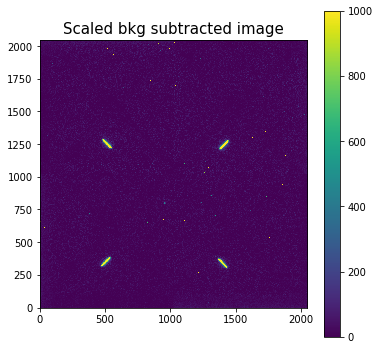

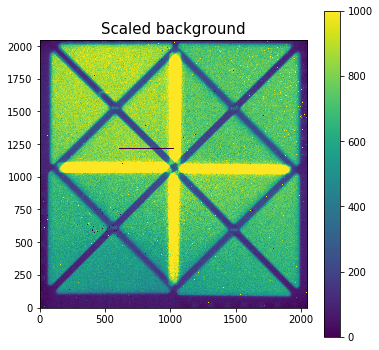

In [25]:
image = wo.wirc_data(sci_frames[5])

#find sources
image.find_sources_v2(sigma_threshold=0)

#let's see what the original image looks like
plt.figure(figsize=(6,6))
plt.title('Original image', fontsize=15)
plt.imshow(image.full_image, origin='lower', vmin=0, vmax=1000)
plt.colorbar()
plt.show()
plt.close()

#then we do the scaled background subtraction using one of the sky frames
image.generate_and_subtract_bkg(method='scaled_bkg', bkg_fn=sky_frames[0], bkg_by_quadrants=True)

#now let's see what the subtracted image looks like
plt.figure(figsize=(6,6))
plt.title('Scaled bkg subtracted image', fontsize=15)
plt.imshow(image.full_image, origin='lower', vmin=0, vmax=1000)
plt.colorbar()
plt.show()
plt.close()

#finally let's see what the model background image looks like as well
plt.figure(figsize=(6,6))
plt.title('Scaled background', fontsize=15)
plt.imshow(image.bkg_image, origin='lower', vmin=0, vmax=1000)
plt.colorbar()
plt.show()
plt.close()

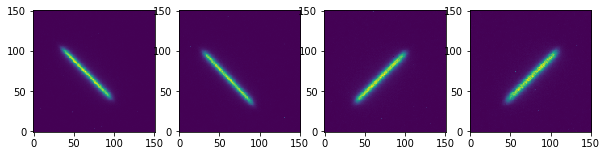

In [27]:
image.source_list[0].get_cutouts(image.full_image, image.DQ_image, image.filter_name,
                                 replace_bad_pixels = True, sub_bar = False, cutout_size = 75)

#plot the traces
fig, ax = plt.subplots(1,4,figsize = (10,4))
for i in range(4):
    ax[i].imshow(image.source_list[0].trace_images[i], origin = 'lower')

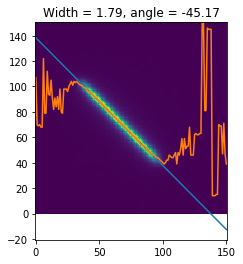

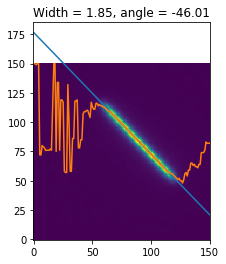

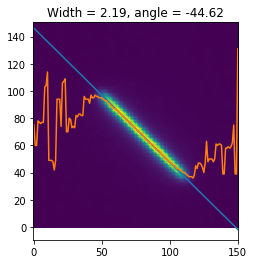

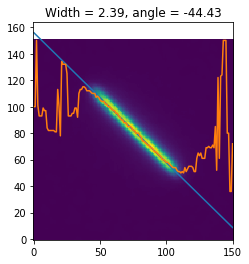

In [28]:
image.source_list[0].extract_spectra(plot=False, 
                                   method="optimal_extraction", 
                                   spatial_sigma=10,
                                   bad_pix_masking = 1,
                                   plot_optimal_extraction = False,
                                   plot_findTrace = True,
                                   verbose=False)

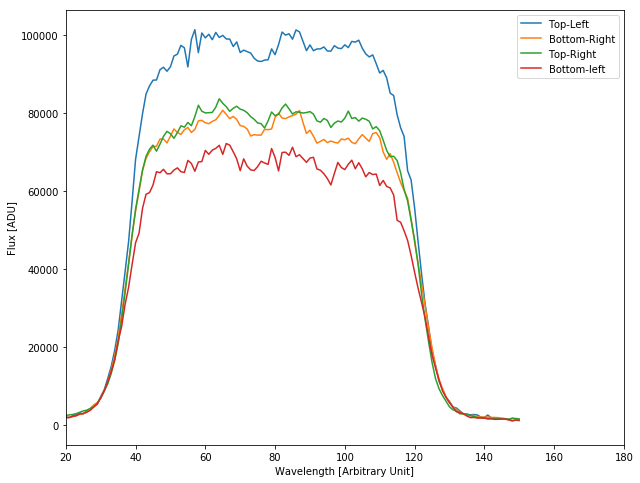

In [29]:
image.source_list[0].plot_trace_spectra(figsize=(10,8), xlow = 20, xhigh = 180)

No Subtraction:
    ---

Just for reference (and fun), let's see what the trace spectra look like with no subtraction

In [30]:
image = wo.wirc_data(sci_frames[5])

#find sources
image.find_sources_v2(sigma_threshold=0, show_plots=False)

Creating a new wirc_data object from file /home/mmnguyen/Research/WIRC+POL/Data/20180421/Science/image0148.fits
Found a J-band filter in the header of file /home/mmnguyen/Research/WIRC+POL/Data/20180421/Science/image0148.fits
Finding sources
Source positions ordered by flux: [(956, 805)]
Trace fluxes: [10528]


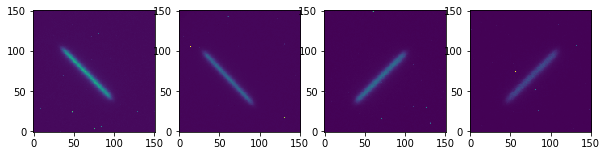

In [31]:
image.source_list[0].get_cutouts(image.full_image, image.DQ_image, image.filter_name,
                                 replace_bad_pixels = True, sub_bar = False, cutout_size = 75)

#plot the traces
fig, ax = plt.subplots(1,4,figsize = (10,4))
for i in range(4):
    ax[i].imshow(image.source_list[0].trace_images[i], origin = 'lower')

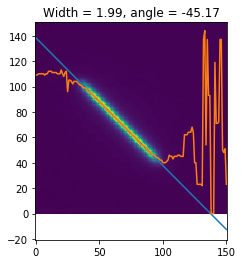

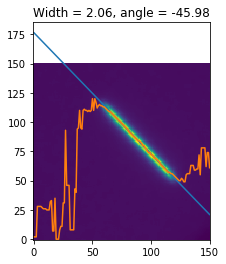

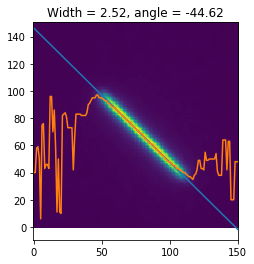

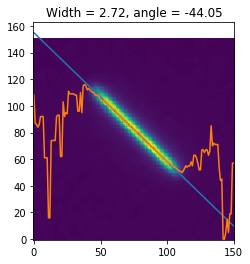

In [32]:
image.source_list[0].extract_spectra(plot=False, 
                                   method="optimal_extraction", 
                                   spatial_sigma=10,
                                   bad_pix_masking = 1,
                                   plot_optimal_extraction = False,
                                   plot_findTrace = True,
                                   verbose=False)

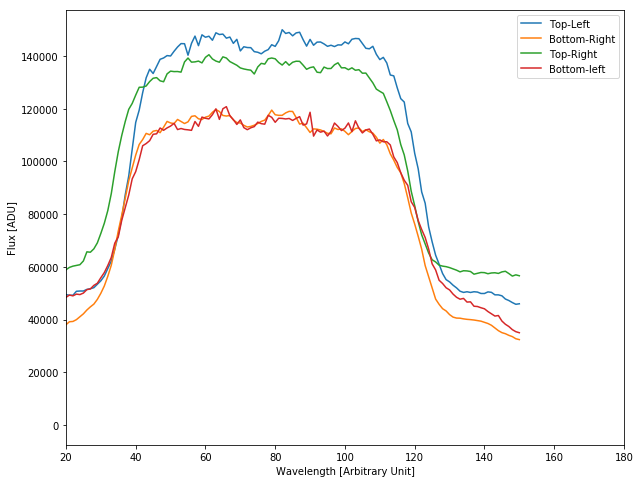

In [36]:
image.source_list[0].plot_trace_spectra(figsize=(10,8), xlow = 20, xhigh = 180)

Source Masking:
-------------

There is also the option to mask sources in the image. If the source positions in the image have not been found
yet, this method will run the source finding algorithm first.

KWARGS:

trace_template: 2-D np.array

    By default, uses the trace_template under wircpol_masks module of wirc_drp, but if you provide a template, it will use that instead. (Default=None)
    
sigma_threshold: fl

    This is the same kwarg as in find_sources_v2(). This is only used if you call mask_sources()
    before running find_sources_v2().
    
boxsize: int

    size of box used to do median fill of traces. (Default=10)
    
save_path: str

    if not None, saves masked image as .fits file to specified path. (Default=None)
    
show_plots: bool

    if True, shows masked image and source finder plots (if source finder not run yet). (Default=True)
    
overwrite: bool

    if True, overwrites full_image with masked image. Else, saves masked image to self.masked_image (Default=False)


Masking sources.


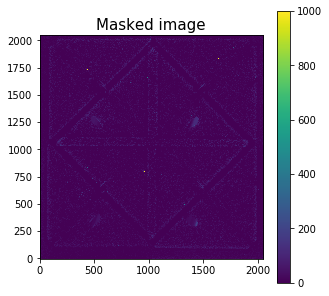

In [14]:
image.mask_sources()

Testing the source finding/masking robustness:
------

Below we've run the source finding/masking algorithm on some random sky frames for fun to test robustness

Creating a new wirc_data object from file /home/mmnguyen/Research/WIRC+POL/Data/20180421/Sky/image0248.fits
Found a J-band filter in the header of file /home/mmnguyen/Research/WIRC+POL/Data/20180421/Sky/image0248.fits
Need to find sources first. Running source finding algorithm.
Finding sources


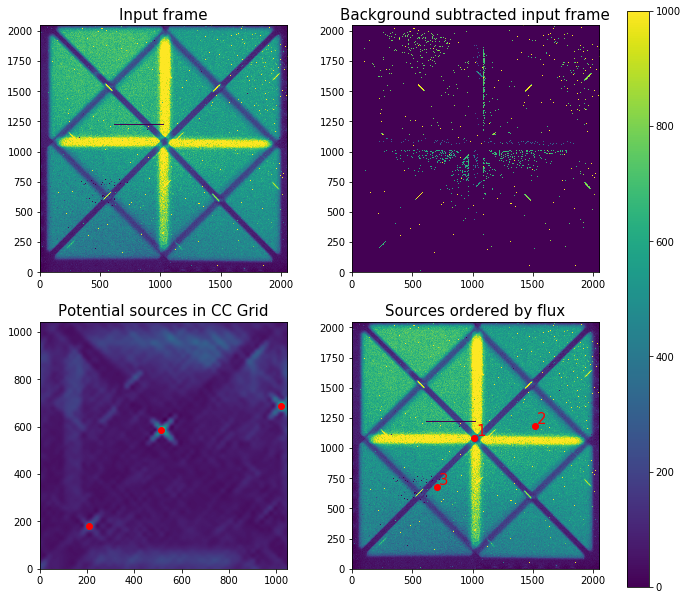

Source positions ordered by flux: [(1010, 1082), (1516, 1182), (703, 678)]
Trace fluxes: [1333, 865, 793]
Masking sources.


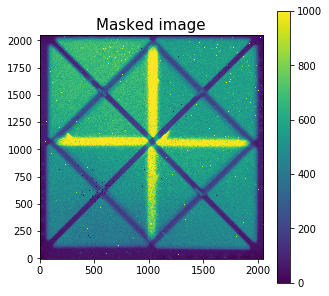

Creating a new wirc_data object from file /home/mmnguyen/Research/WIRC+POL/Data/20180421/Sky/image0354.fits
Found a J-band filter in the header of file /home/mmnguyen/Research/WIRC+POL/Data/20180421/Sky/image0354.fits
Need to find sources first. Running source finding algorithm.
Finding sources


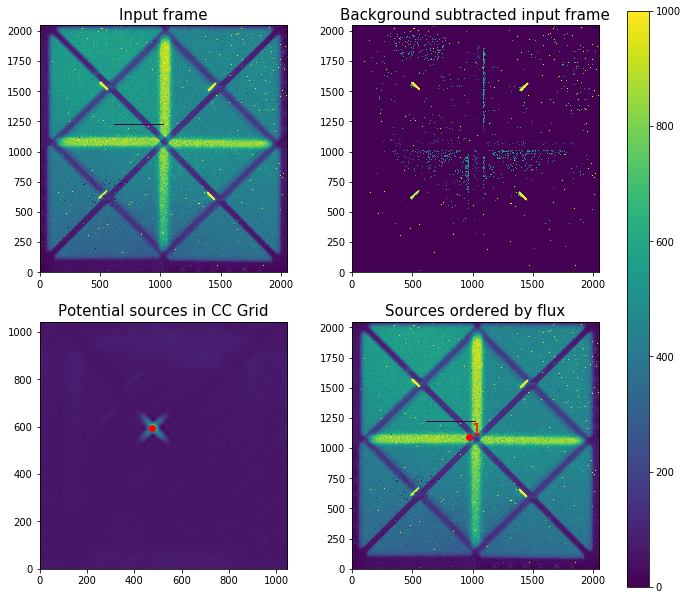

Source positions ordered by flux: [(972, 1091)]
Trace fluxes: [6128]
Masking sources.


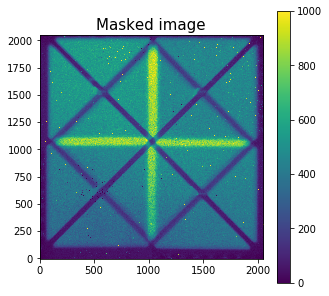

Creating a new wirc_data object from file /home/mmnguyen/Research/WIRC+POL/Data/20180421/Sky/image0482.fits
Found a J-band filter in the header of file /home/mmnguyen/Research/WIRC+POL/Data/20180421/Sky/image0482.fits
Need to find sources first. Running source finding algorithm.
Finding sources


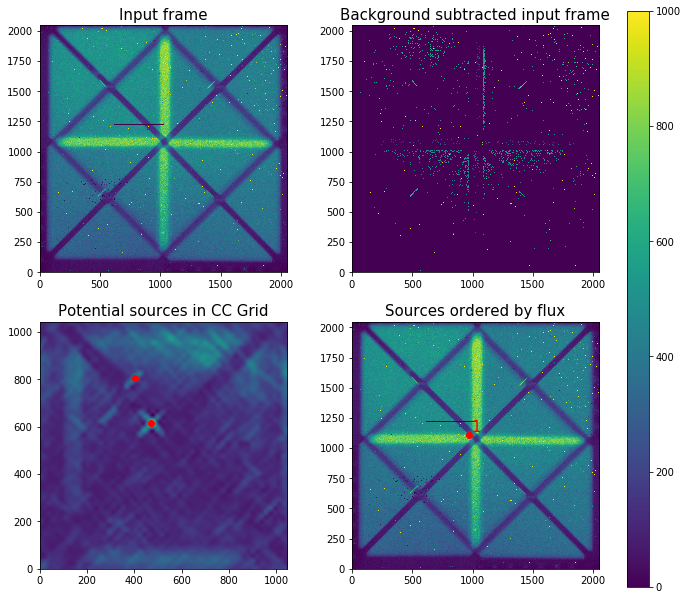

Source positions ordered by flux: [(968, 1112)]
Trace fluxes: [814]
Masking sources.


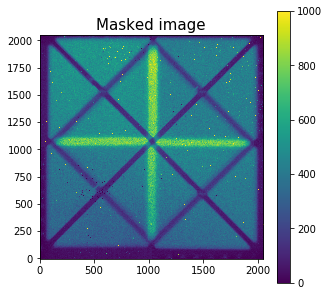

Creating a new wirc_data object from file /home/mmnguyen/Research/WIRC+POL/Data/20180421/Sky/image0608.fits
Found a J-band filter in the header of file /home/mmnguyen/Research/WIRC+POL/Data/20180421/Sky/image0608.fits
Need to find sources first. Running source finding algorithm.
Finding sources


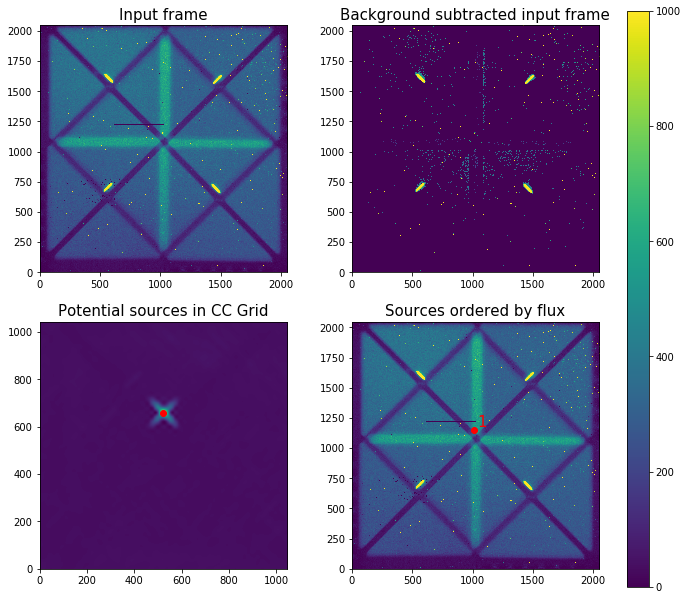

Source positions ordered by flux: [(1016, 1154)]
Trace fluxes: [8847]
Masking sources.


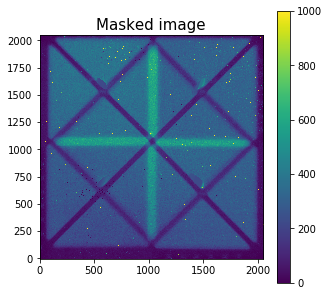

In [12]:
#running the source finding/masking algorithm on some random sky frames for fun to test robustness
for i in [0, 1, 2, 3]:
    sky_frame = wo.wirc_data(sky_frames[i])
    sky_frame.mask_sources()